In [32]:
import pandas as pd
import subprocess
import os
from rs3.seq import predict_seq
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class Args:
    threads = "6"
    mismatches = "5"
    #altpams = NAG
    kmers = "./"
    ouput= ""
    

In [ ]:
os.chdir("./crispomics/")

In [2]:
!ls

filtered_file.csv	   launch.json		SPI1.gff3.db
FilterKmerBED		   out.bed		stdout
finalKmers.bed		   out.gff3		test
GenerateKmerBED		   output.gff3		tmp
gscan.csv		   ProcessAnnotation	trimmedAnnotation.gff
guideScanOut_complete.csv  README.md		trimmed.gtf
guideScanOut.csv	   ScoringGuides.ipynb
kmers.bed		   SPI1.gff3


In [2]:
def guideScanScoring(guideCSV, guideIndex, threads = 2, mismatches = 4):
    tempOutput = './tmp/guideScanOut.csv'
    cmd = [
        'guidescan',
        'enumerate',
        '--max-off-targets',
        '-1',
        '--threads',
        str(threads),
        '--mismatches',
        str(mismatches),
        '--format',
        'csv',
        '--mode',
        'succinct',
        '--kmers-file',
        guideCSV,
        '--output',
        tempOutput,
        guideIndex
    ]

    subprocess.run(cmd, check=True)

    # read the csv file
    gscanDF = pd.read_csv(tempOutput)

    # drop duplicate rows and keep the first occurrence
    gscanDF = gscanDF.drop_duplicates(subset='id', keep='first')

    # write the result to a new csv file
    return gscanDF

In [3]:
def cleavageScoring(kmers, minPercentile = 0.40, tracr = 'Hsu2013', threads = 2):
#start_time = time.time()
    kmerDF = pd.read_csv(kmers, delimiter='\t', \
                         header=0 )
    # guideScores = predict_seq(sgRNAlist, sequence_tracr='Hsu2013', n_jobs=12)

    sgRNAlist = kmerDF['context'].tolist() # 1709 seconds chr21, 12 cores 
    # test
    #kmerDF = kmerDF.head(10005)

    # process the list in chunks to reduce memory footprint
    chunk_size = 100000

    sgRNAScores = []

    # Iterate over big_list in chunks of size chunk_size
    for i in range(0, len(sgRNAlist), chunk_size):
        sublist = sgRNAlist[i:i + chunk_size]
        processed_sublist = predict_seq(sublist, sequence_tracr=tracr, n_jobs=threads)
        sgRNAScores.extend(processed_sublist)

    kmerDF['rs3_z_score'] = sgRNAScores
    kmerDF['rs3_percentile'] = norm.cdf(kmerDF['rs3_z_score'])
    kmerDF['rs3_score_norm'] = (kmerDF['rs3_z_score'] - kmerDF['rs3_z_score'].min()) / (kmerDF['rs3_z_score'].max() - kmerDF['rs3_z_score'].min())
    #kmerDF = kmerDF[kmerDF['rs3_percentile'] > minPercentile]

    kmerDF['id'] = kmerDF['id,sequence,pam,chromosome,position,sense'].str.split(',').str[0]

    return kmerDF


#    end_time = time.time()

In [ ]:
def plotScores()

In [36]:
!pwd

/home/eric/Projects/CrisprLibrary/crispomics


In [7]:
rs3Weight, gscanWeight = 0.67 , 0.33
kmersPerTscript = 10
minSpecificity = 0.5
minRS3 = 0.5

kmerDF = cleavageScoring(kmers = './tmp/loc_filtered_guides.tsv', minPercentile = 0.00)

gscanTMPFile = './tmp/scored_guides_for_guidescan.csv'

kmerDF[['id,sequence,pam,chromosome,position,sense']].to_csv(gscanTMPFile, sep='\t', index=False)
gscanDF = guideScanScoring(guideCSV = gscanTMPFile, guideIndex = '../chr21Index/chr21.fa.index', threads = 2, mismatches = 4)

kmerDF = kmerDF.merge(gscanDF[['id', 'specificity']], on='id', )

kmerDF['combined_score'] = rs3Weight * kmerDF['rs3_score_norm'] + gscanWeight * kmerDF['specificity'] 

kmerDF.sort_values(by='combined_score', inplace=True, ascending=False)

reducedKmerDF = kmerDF.assign(tscripts=kmerDF['tscripts'].str.split(',')).explode('tscripts')

# Step 2: Sort by "combined_score" within each transcript
reducedKmerDF.sort_values(['tscripts', 'combined_score'], ascending=[True, False], inplace=True)

# Step 3: Keep only the top 10 entries per transcript
reducedKmerDF = reducedKmerDF.groupby('tscripts').head(kmersPerTscript)

cols = reducedKmerDF.columns.tolist()  # get a list of all columns
cols.remove('tscripts')  # remove 'tscripts' from this list

finalKmerDF = reducedKmerDF.groupby(cols, as_index=False)['tscripts'].apply(','.join).reset_index()

Calculating sequence-based features


100%|██████████████████████████████████████████| 89/89 [00:00<00:00, 156.96it/s]


[2023-08-01 12:38:31.782] [guidescan2] [info] Loading genome index at "../chr21Index/chr21.fa.index".
[2023-08-01 12:38:31.862] [guidescan2] [info] Successfully loaded genome index.
[2023-08-01 12:38:31.862] [guidescan2] [info] Loading kmers.
[2023-08-01 12:38:31.863] [guidescan2] [info] Read in 89 kmer(s).
[2023-08-01 12:38:33.778] [guidescan2] [info] Processed 89 kmers in 1 seconds.


<Axes: ylabel='Frequency'>

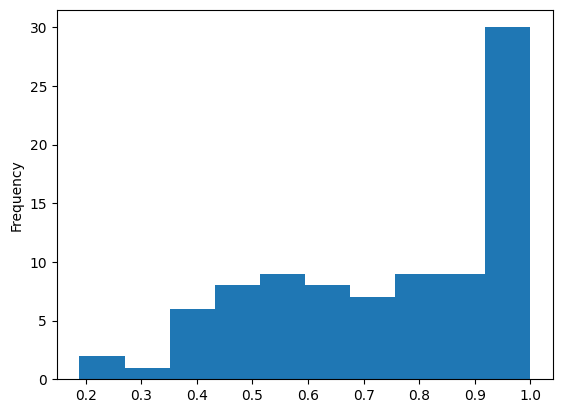

In [13]:
kmerDF['specificity'].plot.hist()


<Axes: ylabel='Frequency'>

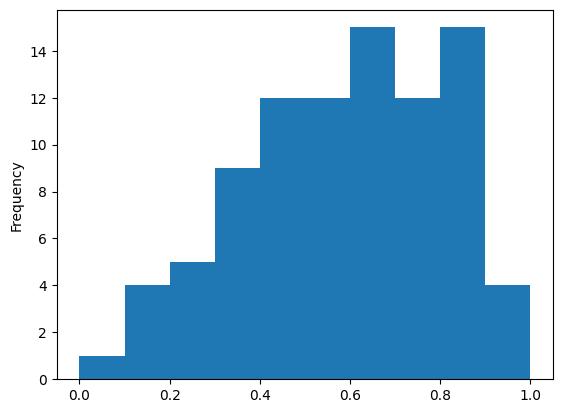

In [22]:
kmerDF['rs3_score_norm'].plot.hist()


Number of guides beyond cutoff: 13


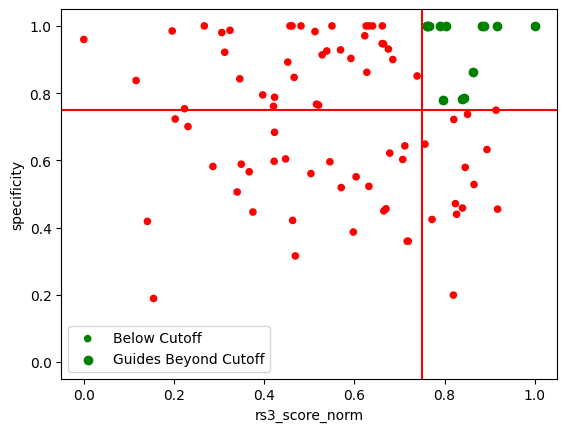

In [35]:
minSpecificity = 0.75
minCleavage = 0.75

# Create a new column "color" based on condition
conditions = [
    (kmerDF['rs3_score_norm'] >= minCleavage) & (kmerDF['specificity'] >= minSpecificity),
    (kmerDF['rs3_score_norm'] < minCleavage) | (kmerDF['specificity'] < minSpecificity),
]

choices = ['green', 'red']

kmerDF['color'] = np.select(conditions, choices, default='black')

# Plot with colors
ax = kmerDF.plot.scatter(x='rs3_score_norm', y='specificity', c=kmerDF['color'], label='Below Cutoff')

# Adding scatter plot for above cutoff points with different color and label
aboveCutoff = kmerDF[kmerDF['color'] == 'green']
ax.scatter(above_cutoff['rs3_score_norm'], aboveCutoff['specificity'], color='green', label='Guides Beyond Cutoff')

# Add horizontal line at y-position minSpecificity
ax.axhline(minSpecificity, color='red')

# Add vertical line at x-position minCleavage
ax.axvline(minCleavage, color='red')

# Set x and y axes limits
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

# Show legend
plt.legend()

# Show the number of guides beyond cutoff
availableGuides = len(aboveCutoff)
print(f"Number of guides beyond cutoff: {availableGuides}")

plt.show()